In [75]:
from bs4 import BeautifulSoup
from collections import OrderedDict
import json
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [27]:
# url to scrape
url_to_scrape = 'http://insightdatascience.com/fellows'
r = requests.get(url_to_scrape)
# Create a beautifulsoup object from html content
soup = BeautifulSoup(r.text,"html.parser")

In [28]:
# fellows are stored in lists with 100 elements in each. We
# take each element and within each list we find info of fellows.
rosters = soup.findAll('div', class_="fellows_list w-dyn-list")

In [29]:
data = {'Name':[],'Title':[],'Company':[],'Project':[],'Background':[], 'Flag':[]}

In [30]:
for i,roster in enumerate(rosters):
    fellows = roster.findAll('div', class_="w-clearfix w-dyn-items w-row")
    if len(fellows)!=0:
        fellows = fellows[0].findAll('div', class_='fellow_item w-dyn-item w-col w-col-2')
        for fellow in fellows[:]:
            
            #print (BeautifulSoup.prettify(fellow))
            exception = False
            
            try:
                name = fellow.find('div', class_="tooltip_name").text
                data['Name'].append(name)
            except:
                exception = True
                data['Name'].append('')
            
            title = fellow.find('div', class_="toottip_title").text
            #print (fellow.findAll('div', class_="toottip_title"))
            data['Title'].append(title)
            
            try:
                company = fellow.find('div', class_="tooltip_company").text
                data['Company'].append(company)
            except: 
                exception = True
                data['Company'].append('')
            
            project = fellow.find('div', class_="tooltip_project").text
            data['Project'].append(project)
            
            background = fellow.find('div', class_="tooltip_background").text
            if len(background.split(','))==3:
                data['Background'].append(background)
            else:
                exception = True
                data['Background'].append(background)
            
            if exception:
                data['Flag'].append(1)
            else:
                data['Flag'].append(0)

In [31]:
columns = ['Name','Title','Company','Project','Background','Flag']
df = pd.DataFrame(data,columns=columns)
df = df[df['Flag']!=1]
background_split = df['Background'].apply(lambda x: pd.Series(x.split(',')))
background_split.rename(columns={0:'Major',1:'University',2:'Degree'},inplace=True)
background_split = background_split[['Major','University','Degree']]
df.drop('Background',1,inplace=True)
df = pd.concat([df,background_split],axis=1)
df['Degree'] = df['Degree'].replace({r'[^\x00-\x7F]+':'',r'\n':''}, regex=True, inplace=False)
df['Name'] = df['Name'].replace({r'[^\x00-\x7F]+':'',r'\n':''}, regex=True, inplace=False)

## Most represented schools

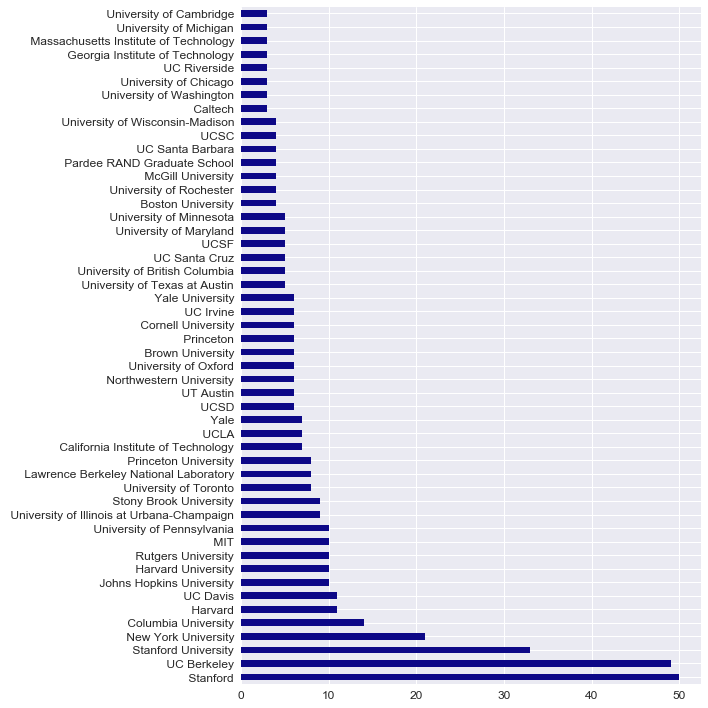

In [89]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
df['University'].value_counts(ascending=False)[0:50].plot(kind='barh',ax=ax, cmap = 'plasma')
plt.tight_layout()
plt.show(fig)
fig.savefig("most_represented_schools.png", dpi = 500, transparent=False) 

## Least represented schools

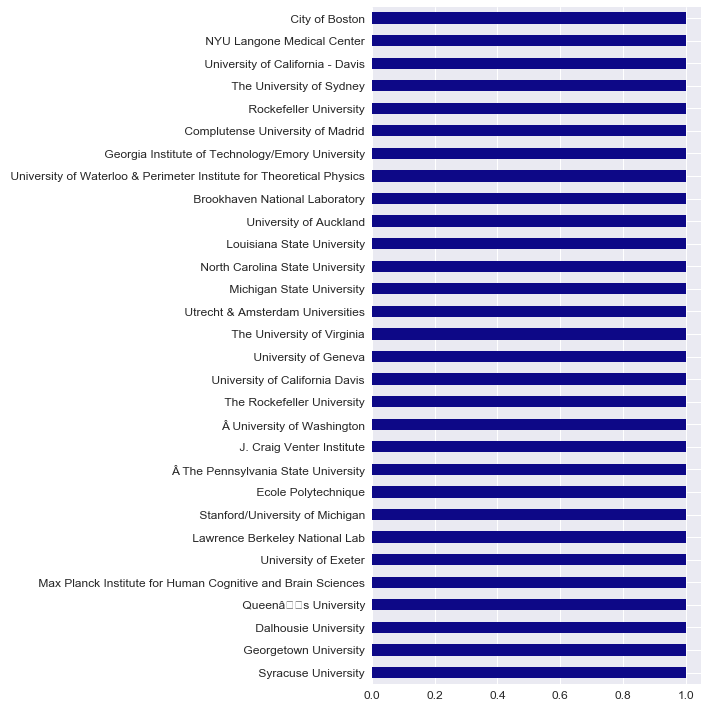

In [85]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
df['University'].value_counts()[-30:].plot(kind='barh',ax=ax,cmap = 'plasma')
plt.tight_layout()
plt.show(fig)
fig.savefig("least_represented_schools.png", dpi = 500, transparent=False) 

## Degree

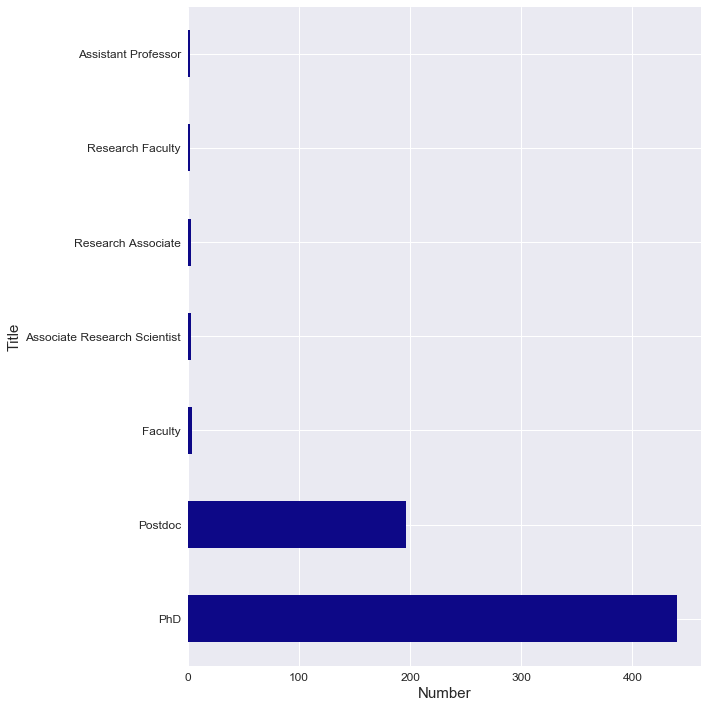

In [86]:
def clean_text(row):
    # return the list of decoded cell in the Series instead 
    return row.encode('ascii', 'ignore').strip().decode('utf-8')

df['Degree'] = df['Degree'].apply(lambda x: clean_text(x))

fig,ax = plt.subplots(1,1,figsize=(10,10))
df['Degree'].value_counts()[:7].plot(kind='barh',ax=ax,cmap = 'plasma')
ax.set_xlabel('Number')
ax.set_ylabel('Title')
plt.tight_layout()
plt.show(fig)
fig.savefig("degrees.png", dpi = 500, transparent=False) 

## Major

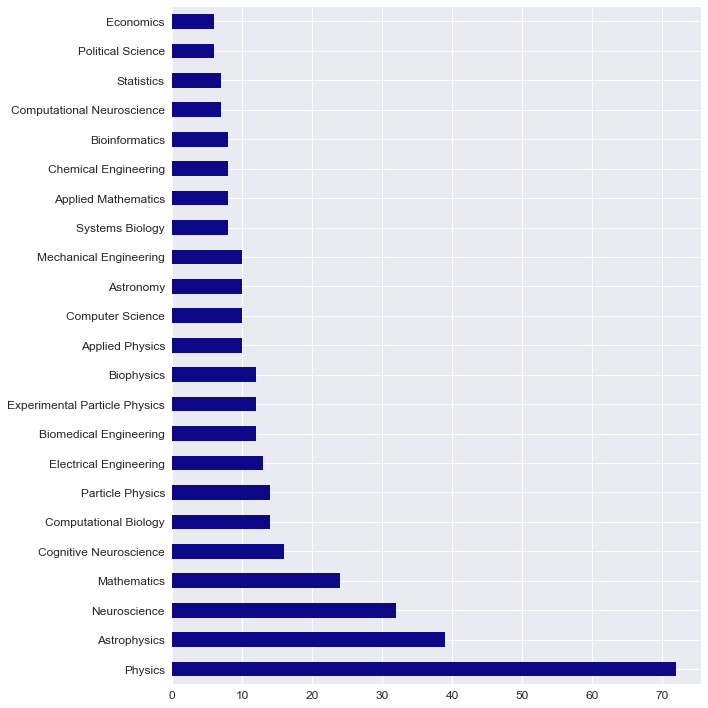

In [87]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
participants = df['Major'].value_counts()
mask = participants > 5 # majors with more than 5 participants
participants[mask].plot(kind='barh',ax=ax, cmap = 'plasma')
plt.tight_layout()
plt.show(fig)
fig.savefig("majors.png", dpi = 500, transparent=False) 

## Companies

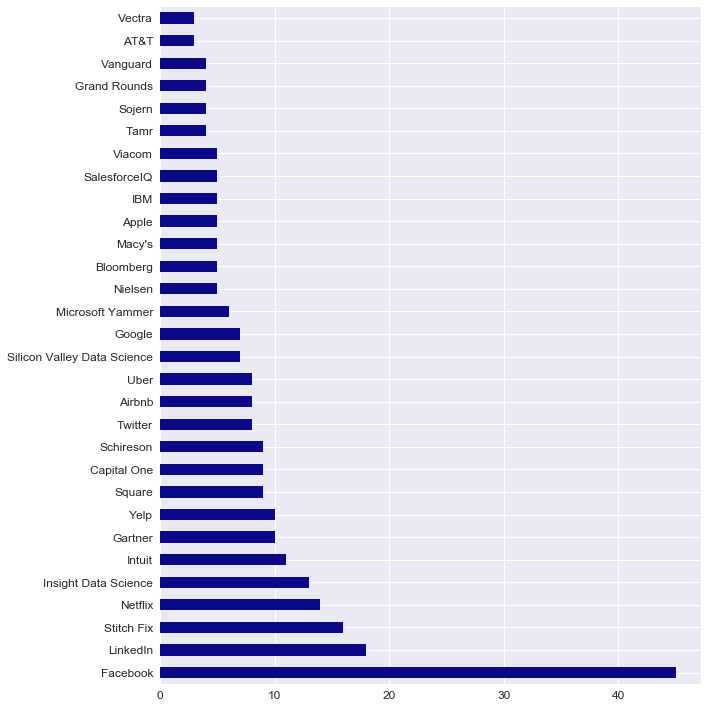

In [88]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
df['Company'].value_counts()[1:31].plot(kind='barh',ax=ax, cmap = 'plasma')
plt.tight_layout()
plt.show(fig)
fig.savefig("companies.png", dpi = 500, transparent=False) 

# Which companies

In [78]:
results = set()
df[df['Company']=='Google'][['Project','Major']]

,Project,Major
181,YC Predictor: Predicting the likelihood of a Y...,Cognitive Neuroscience
188,Pharmdout: Classifying and predicting active p...,Mathematical Biology
195,NestPricer:Â Helping new residents estimate th...,Computer Science
210,Analyzing Analysts: Understanding the Queriers...,Biophysics
227,FutureCast: Predicting the rate of city-wide e...,Mathematics
373,Illseeitall: Optimize your schedule to see the...,Chemical Physics
389,Default Detection: Predicting micro-loan fraud...,Energy Engineering


# Heatmap of degree and Major

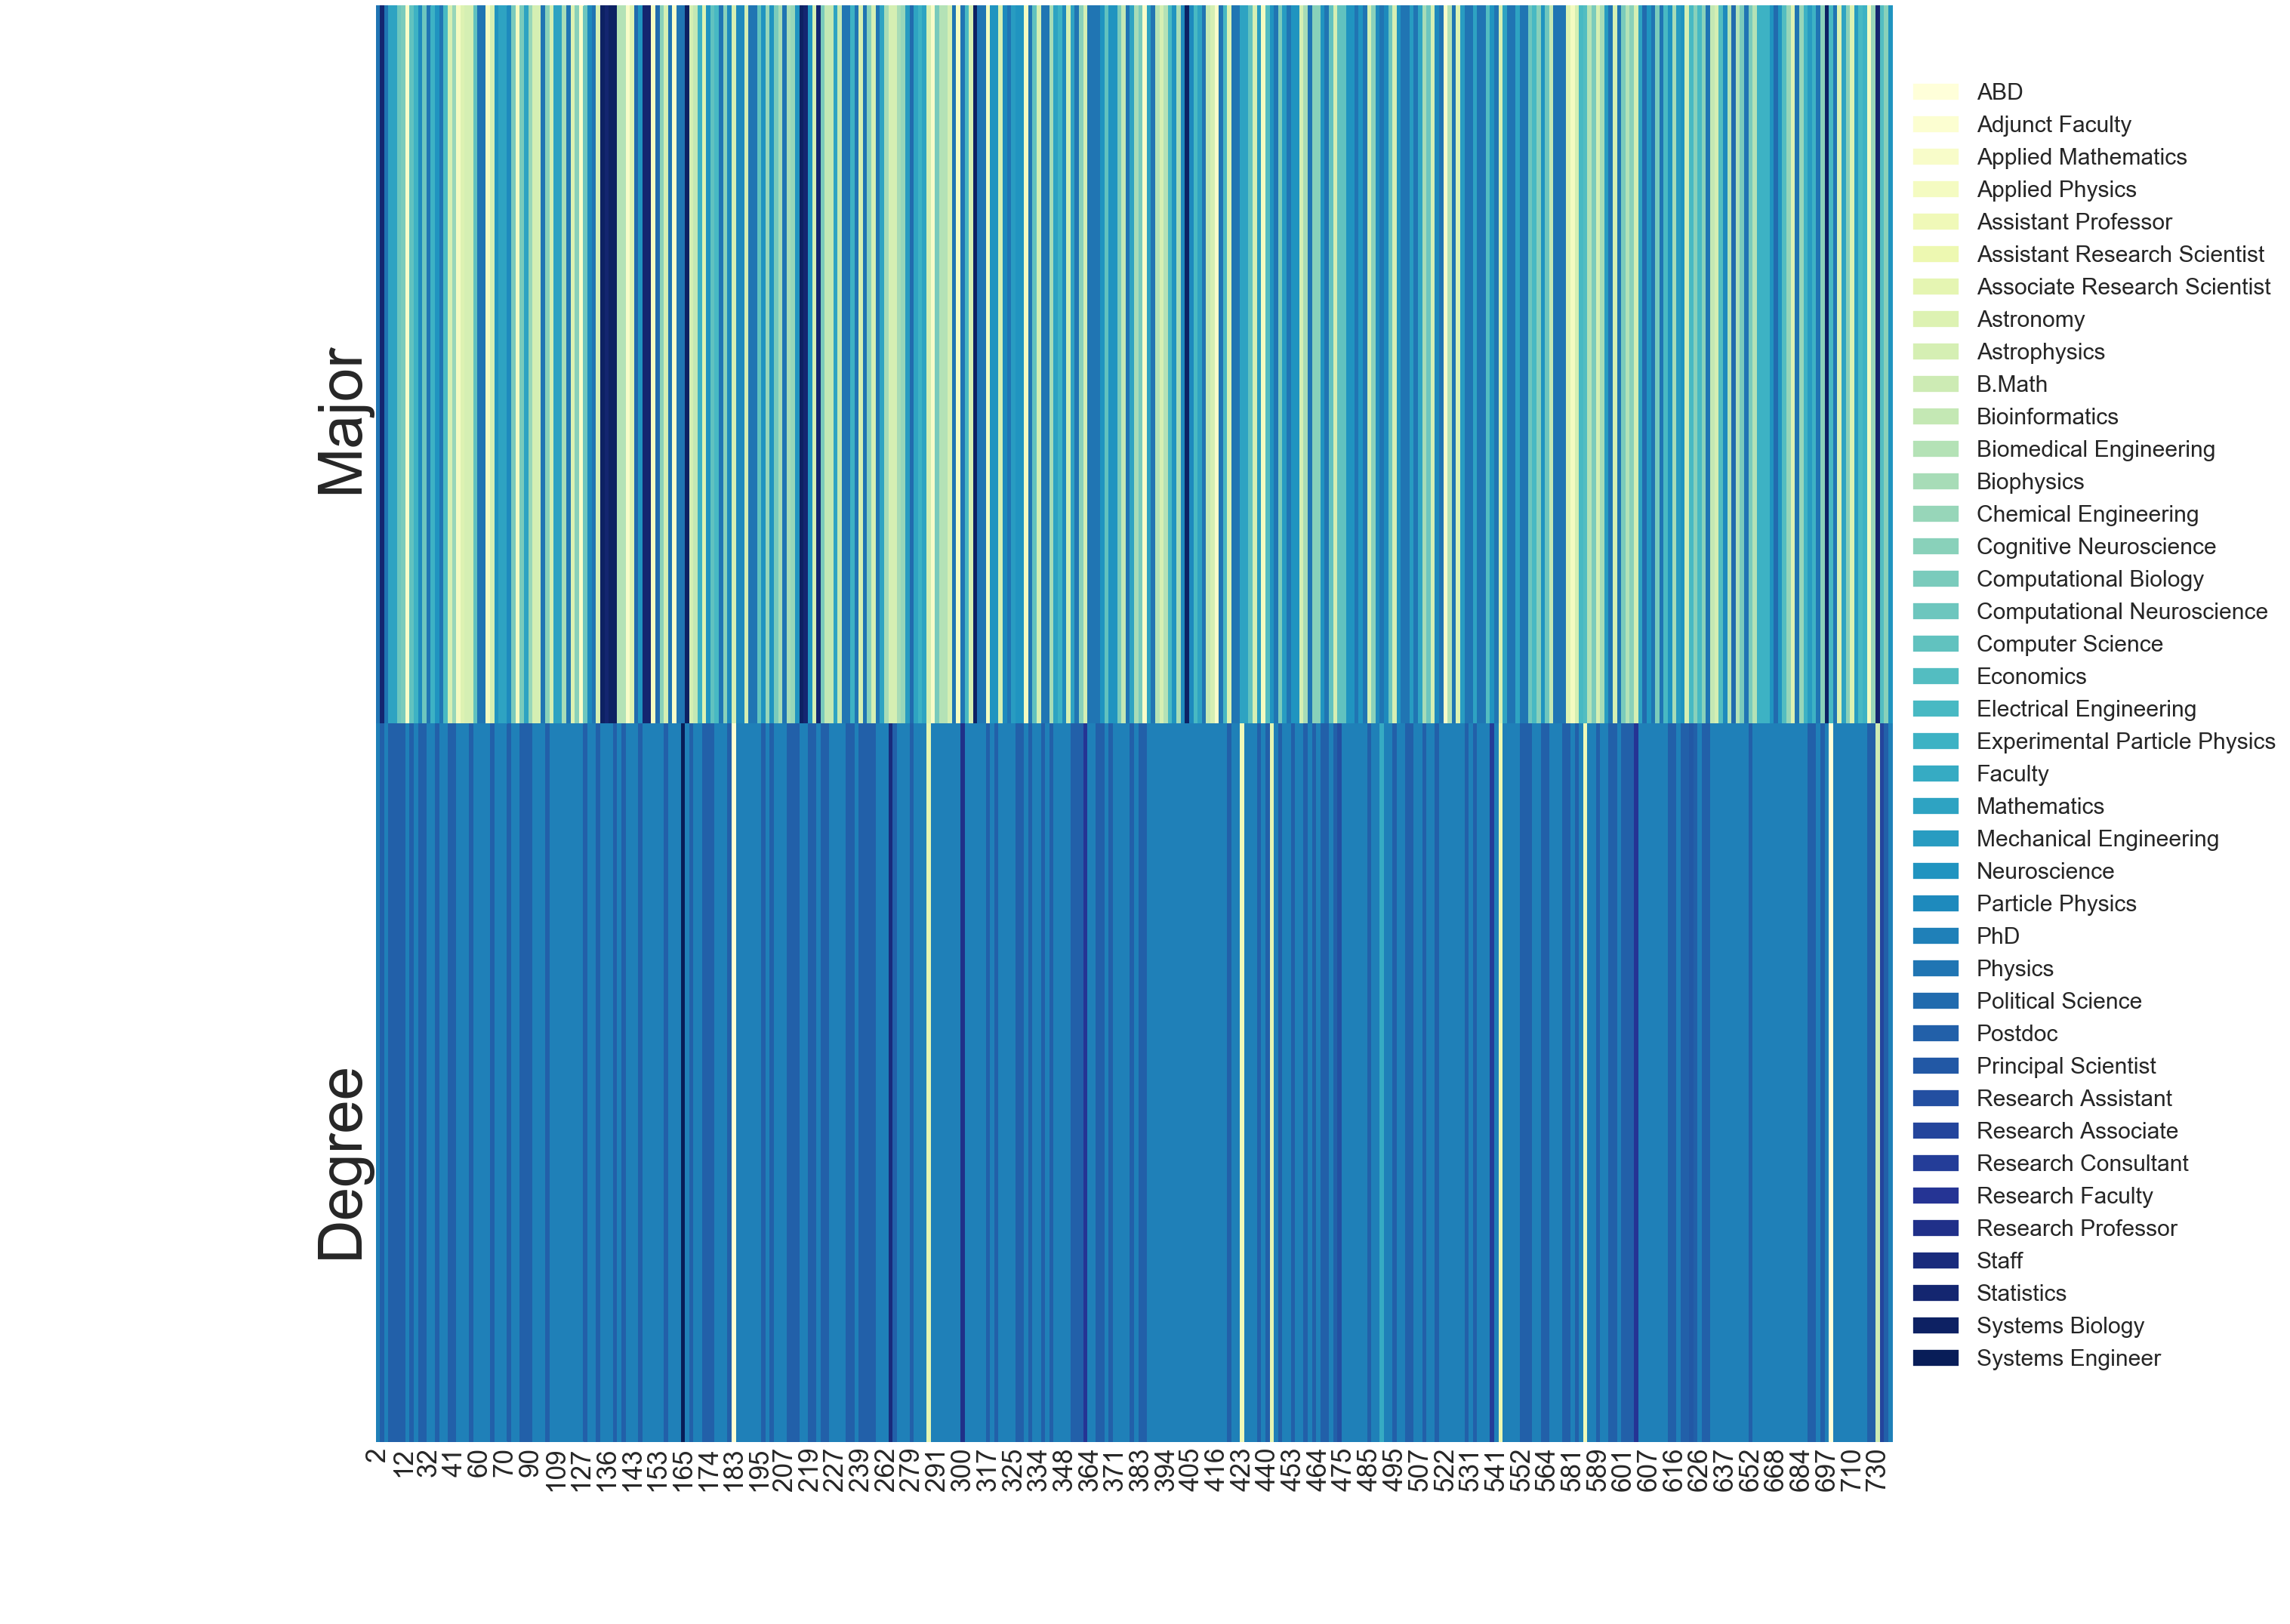

In [21]:
mask_major = df['Major'].apply(lambda x: x in participants[mask].index)

plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['legend.fontsize'] = 30
plt.rcParams['xtick.labelsize'] = 35
plt.rcParams['ytick.labelsize'] = 80

dg = df[mask_major][['Major','Degree']]
# create dictionary with value to integer mappings
value_to_int = {value: i for i, value in enumerate(sorted(pd.unique(dg.values.ravel())))}

f, ax = plt.subplots(figsize=(45,35))
hm = sns.heatmap(dg.replace(value_to_int).T, cmap="YlGnBu", ax=ax, cbar=False)
# add legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*0.8 , box.height])
legend_ax = f.add_axes([0.01, 0.05, 0.2, 0.2])
legend_ax.axis('off')
# reconstruct color map
colors = plt.cm.YlGnBu(np.linspace(0, 1, len(value_to_int)))
# add color map to legend
patches = [mpatches.Patch(facecolor=c, edgecolor=c) for c in colors]
legend = legend_ax.legend(patches,
    sorted(value_to_int.keys()),
    handlelength=2, loc='upper right', bbox_to_anchor=(4.5, 4))
for t in legend.get_texts():
    t.set_ha("left")